In [1]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np

/home/sennis/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [9]:
# read in datasets
gran = sc.read('../data/granja/granja.h5ad')
gran.obs['dataset'] = 'granja'
gran.obs['sample'] = gran.obs['Group']
gran.obs = gran.obs[['dataset', 'sample', 'celltype']]
gran.X = gran.layers['counts'].copy()
del gran.uns, gran.layers['counts']
gran

AnnData object with n_obs × n_vars = 20558 × 20287
    obs: 'dataset', 'sample', 'celltype'

In [15]:
vang = sc.read('../data/van_Galen/van_Galen_healthy.h5ad')
vang.obs = vang.obs[['dataset', 'sample', 'donor', 'celltype']]
vang.X = vang.layers['counts'].copy()
del vang.uns, vang.obsm, vang.varm, vang.obsp, vang.layers['counts'], vang.var['highly_variable'], vang.var['means'], vang.var['dispersions'], vang.var['dispersions_norm']
vang

AnnData object with n_obs × n_vars = 7698 × 27899
    obs: 'dataset', 'sample', 'donor', 'celltype'

In [17]:
oet = sc.read('../data/oetjen/oetjen.h5ad')
oet.obs['dataset'] = 'oetjen'
oet.obs['donor'] = oet.obs['patient']
oet.obs = oet.obs[['dataset', 'sample', 'donor', 'celltype']]
oet.X = oet.layers['counts'].copy()
del oet.layers['counts'], oet.uns, oet.obsm, oet.varm, oet.obsp, oet.var['highly_variable'], oet.var['means'], oet.var['dispersions'], oet.var['dispersions_norm']
oet

AnnData object with n_obs × n_vars = 73050 × 20613
    obs: 'dataset', 'sample', 'donor', 'celltype'

In [19]:
han = sc.read('../data/han/han.h5ad')
han.obs['dataset'] = 'han'
han.obs['sample'] = han.obs['sample_ID']
han.obs = han.obs[['dataset', 'sample', 'celltype']]
han.X = han.layers['counts'].copy()
del han.uns, han.obsm, han.obsp, han.varm, han.layers['counts'], han.var['highly_variable'], han.var['means'], han.var['dispersions'], han.var['dispersions_norm']
han

AnnData object with n_obs × n_vars = 8704 × 11561
    obs: 'dataset', 'sample', 'celltype'

In [22]:
pet = sc.read('../data/petti/petti_healthy.h5ad')
pet.obs['dataset'] = 'petti'
pet.obs = pet.obs[['dataset', 'sample', 'celltype']]
pet.X = pet.layers['counts'].copy()
del pet.layers['counts'], pet.obsm, pet.obsp, pet.uns, pet.varm, pet.var['highly_variable'], pet.var['means'], pet.var['dispersions'], pet.var['dispersions_norm'], pet.var['n_cells']
pet

AnnData object with n_obs × n_vars = 18471 × 17887
    obs: 'dataset', 'sample', 'celltype'

In [35]:
adatas = [gran, vang, oet, han, pet]
adata_merge = adatas[0].concatenate(adatas[1:], batch_key='sample_ID')
adata_merge

/home/sennis/anaconda3/lib/python3.7/site-packages/anndata/_core/merge.py:894: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,


AnnData object with n_obs × n_vars = 128481 × 9774
    obs: 'dataset', 'sample', 'celltype', 'donor', 'sample_ID'

In [36]:
adata_merge.write('../data/all_healthy.h5ad')

... storing 'dataset' as categorical
... storing 'sample' as categorical
... storing 'celltype' as categorical
... storing 'donor' as categorical


In [37]:
adata_merge.raw = adata_merge
sc.pp.normalize_total(adata_merge)
sc.pp.log1p(adata_merge)
sc.pp.highly_variable_genes(
    adata_merge,
    n_top_genes=2000,
    batch_key="sample",
    subset=True)

/home/sennis/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:504: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:n_top_genes, 'highly_variable'] = True


In [38]:
adata_merge.X = adata_merge.raw[:, adata_merge.var_names].X

In [39]:
sca.dataset.setup_anndata(adata_merge, batch_key="sample")

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/home/sennis/anaconda3/lib/python3.7/site-packages/scvi/data/_anndata.py:811: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc


INFO     Successfully registered anndata object containing 128481 cells, 2000 vars, 41       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [40]:
vae = sca.models.SCVI(
    adata_merge,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [43]:
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
vae.train(max_epochs=50)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

/home/sennis/anaconda3/lib/python3.7/site-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 50/50: 100%|██████████| 50/50 [22:34<00:00, 27.08s/it, loss=709, v_num=1]


In [44]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)

In [45]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["celltype"] = adata_merge.obs["celltype"].tolist()
reference_latent.obs["sample"] = adata_merge.obs["sample"].tolist()
reference_latent.obs["dataset"] = adata_merge.obs["dataset"].tolist()

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


/home/sennis/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/sennis/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/sennis/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/sennis/anaconda3/lib/python3.

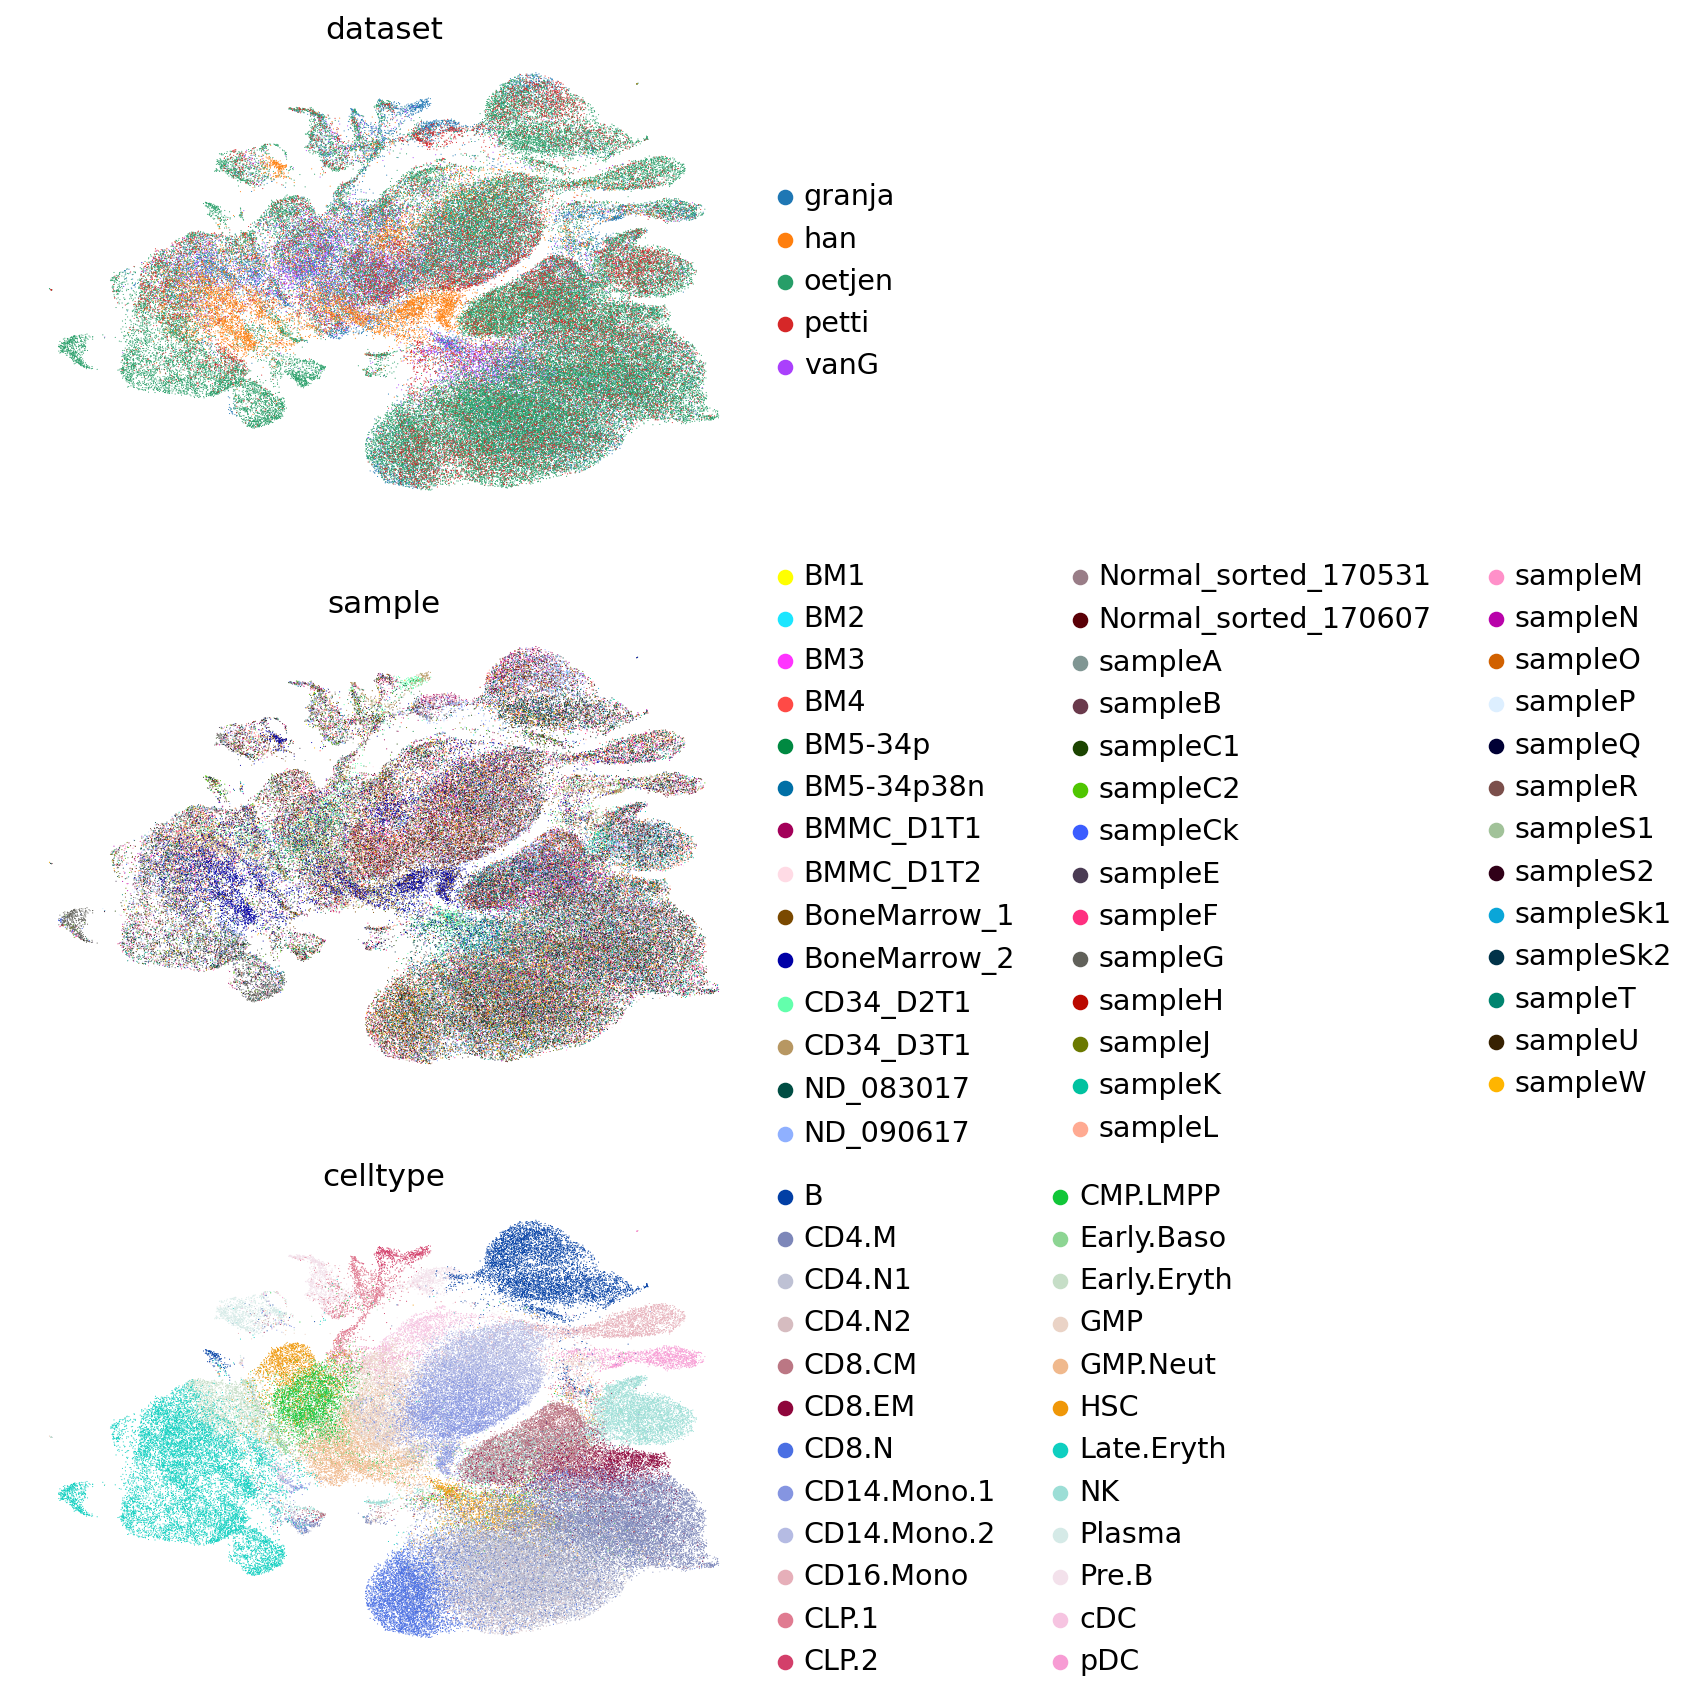

In [46]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['dataset', 'sample', 'celltype'],
           frameon=False,
           wspace=0.6,
           ncols=1)

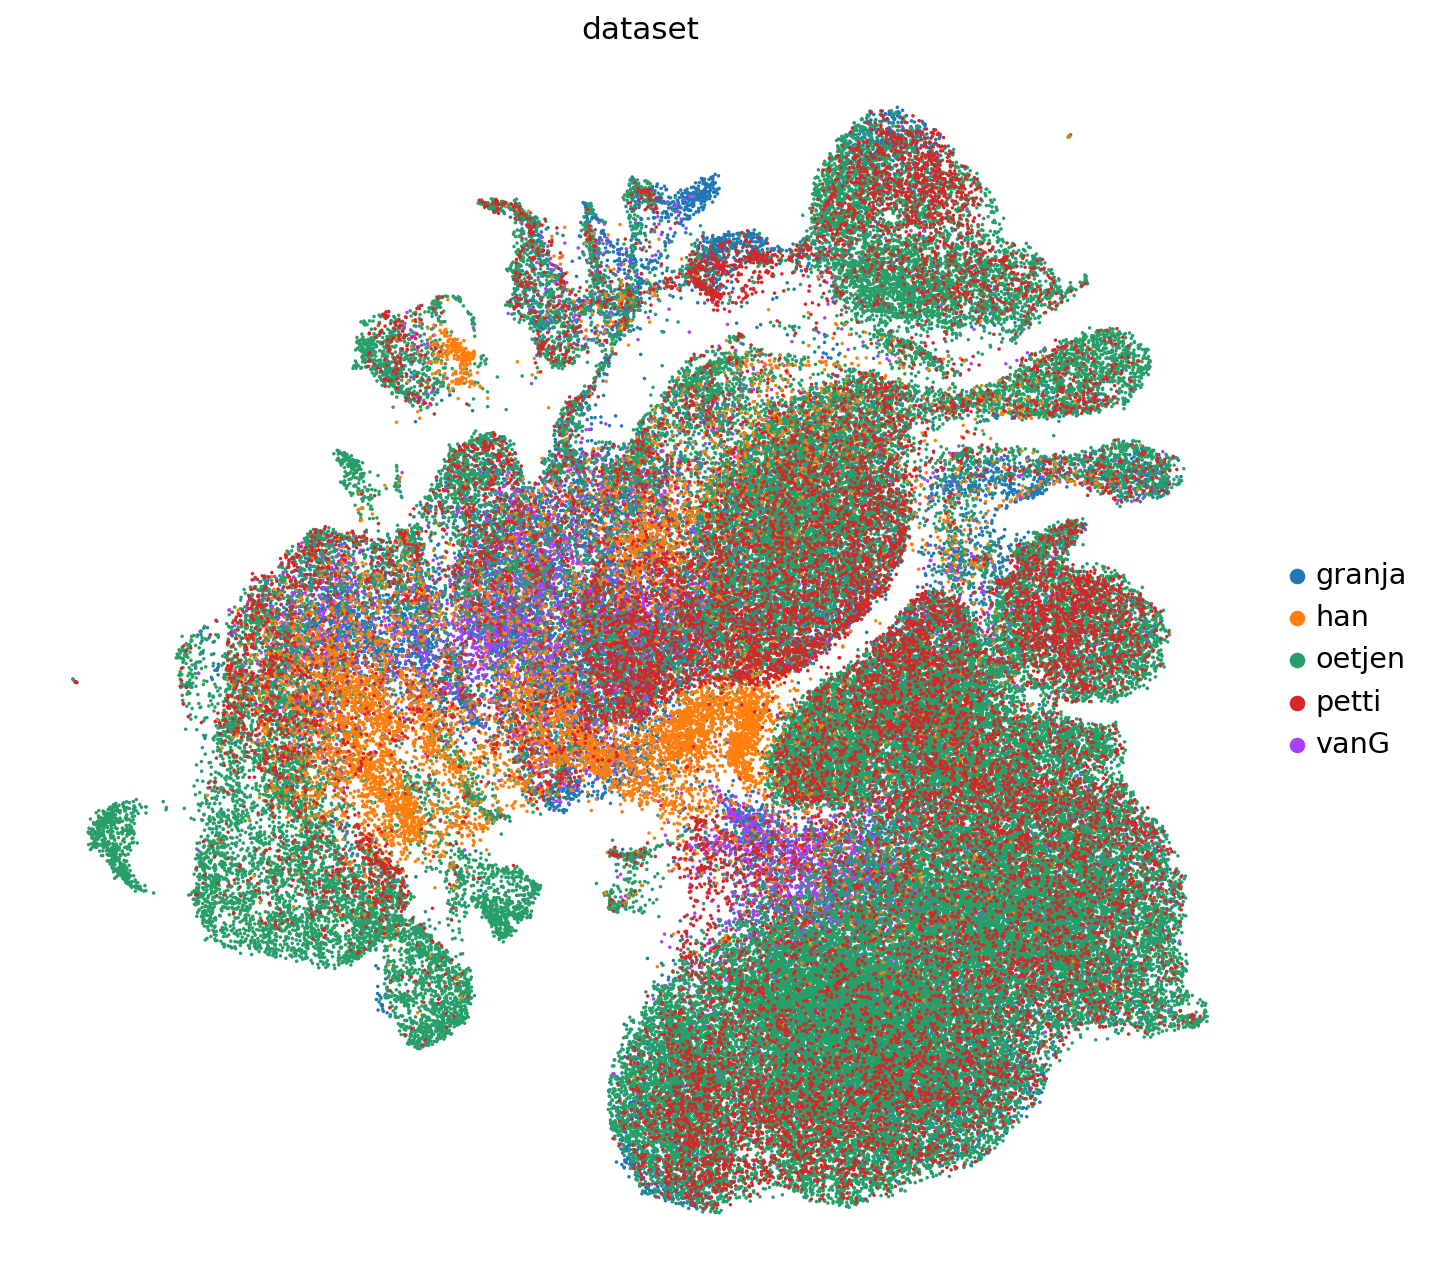

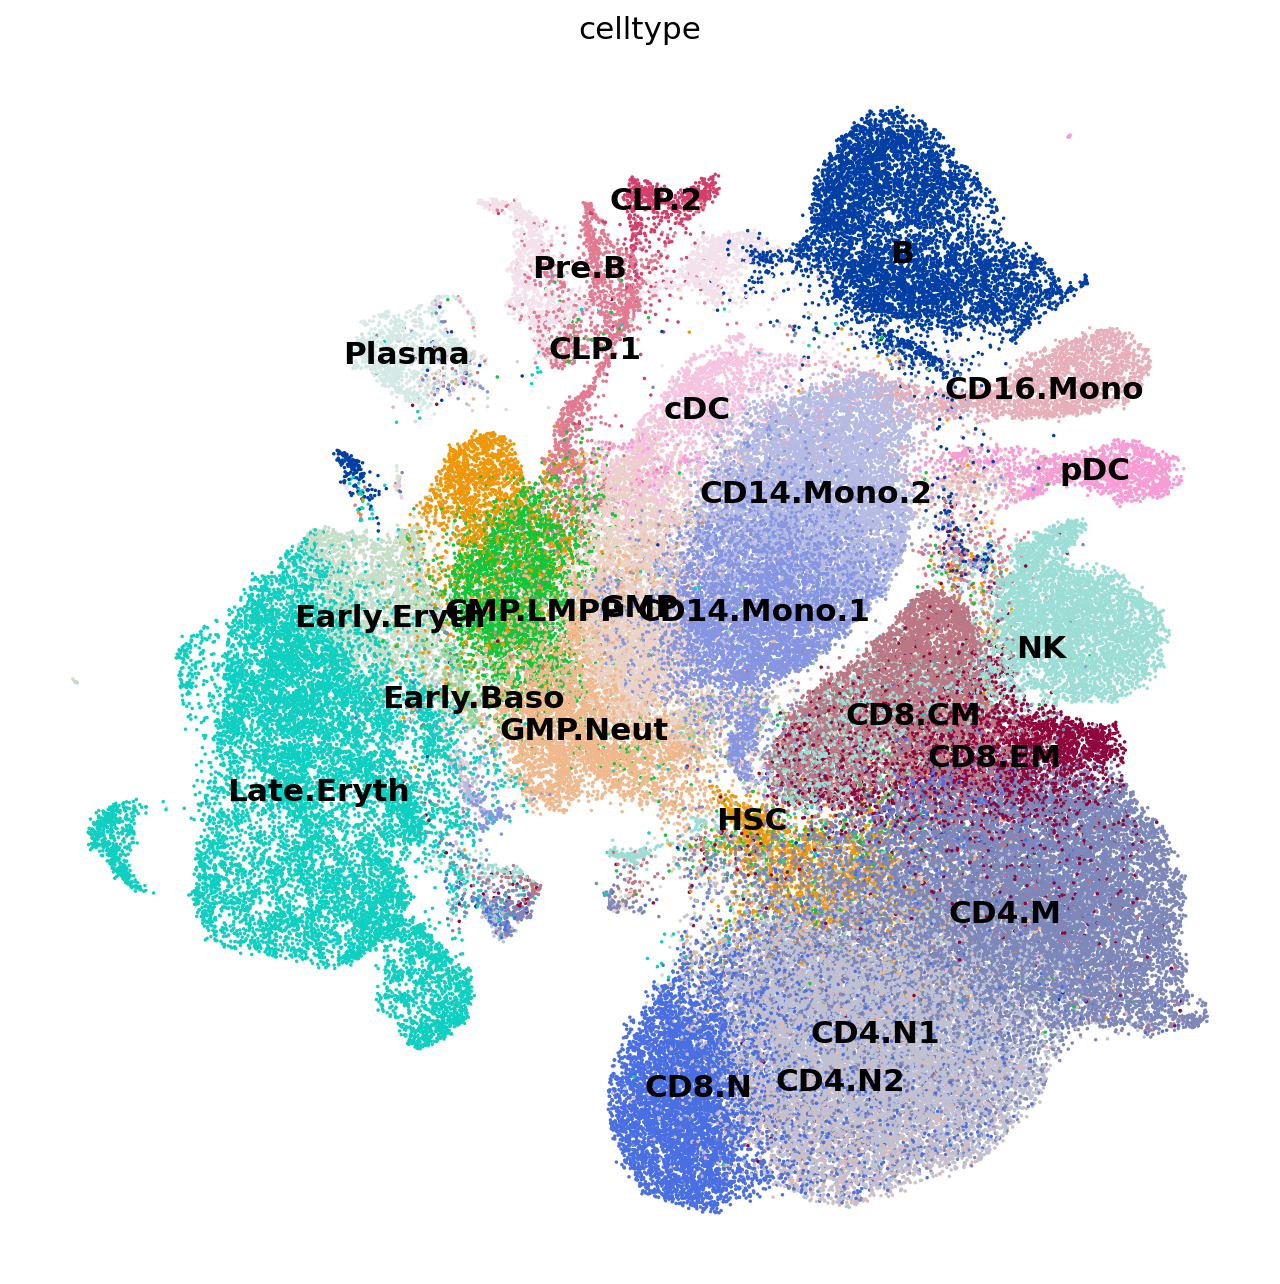

In [53]:
sc.set_figure_params(figsize=(10, 10))
sc.pl.umap(reference_latent, color=['dataset'], frameon=False,
           wspace=0.6, size=10, ncols=1)
sc.pl.umap(reference_latent, color=['celltype'], legend_loc='on data', frameon=False,
           wspace=0.6, size=10, ncols=1)

In [49]:
reference_latent.write('../data/reference_latent.h5ad')

... storing 'donor' as categorical


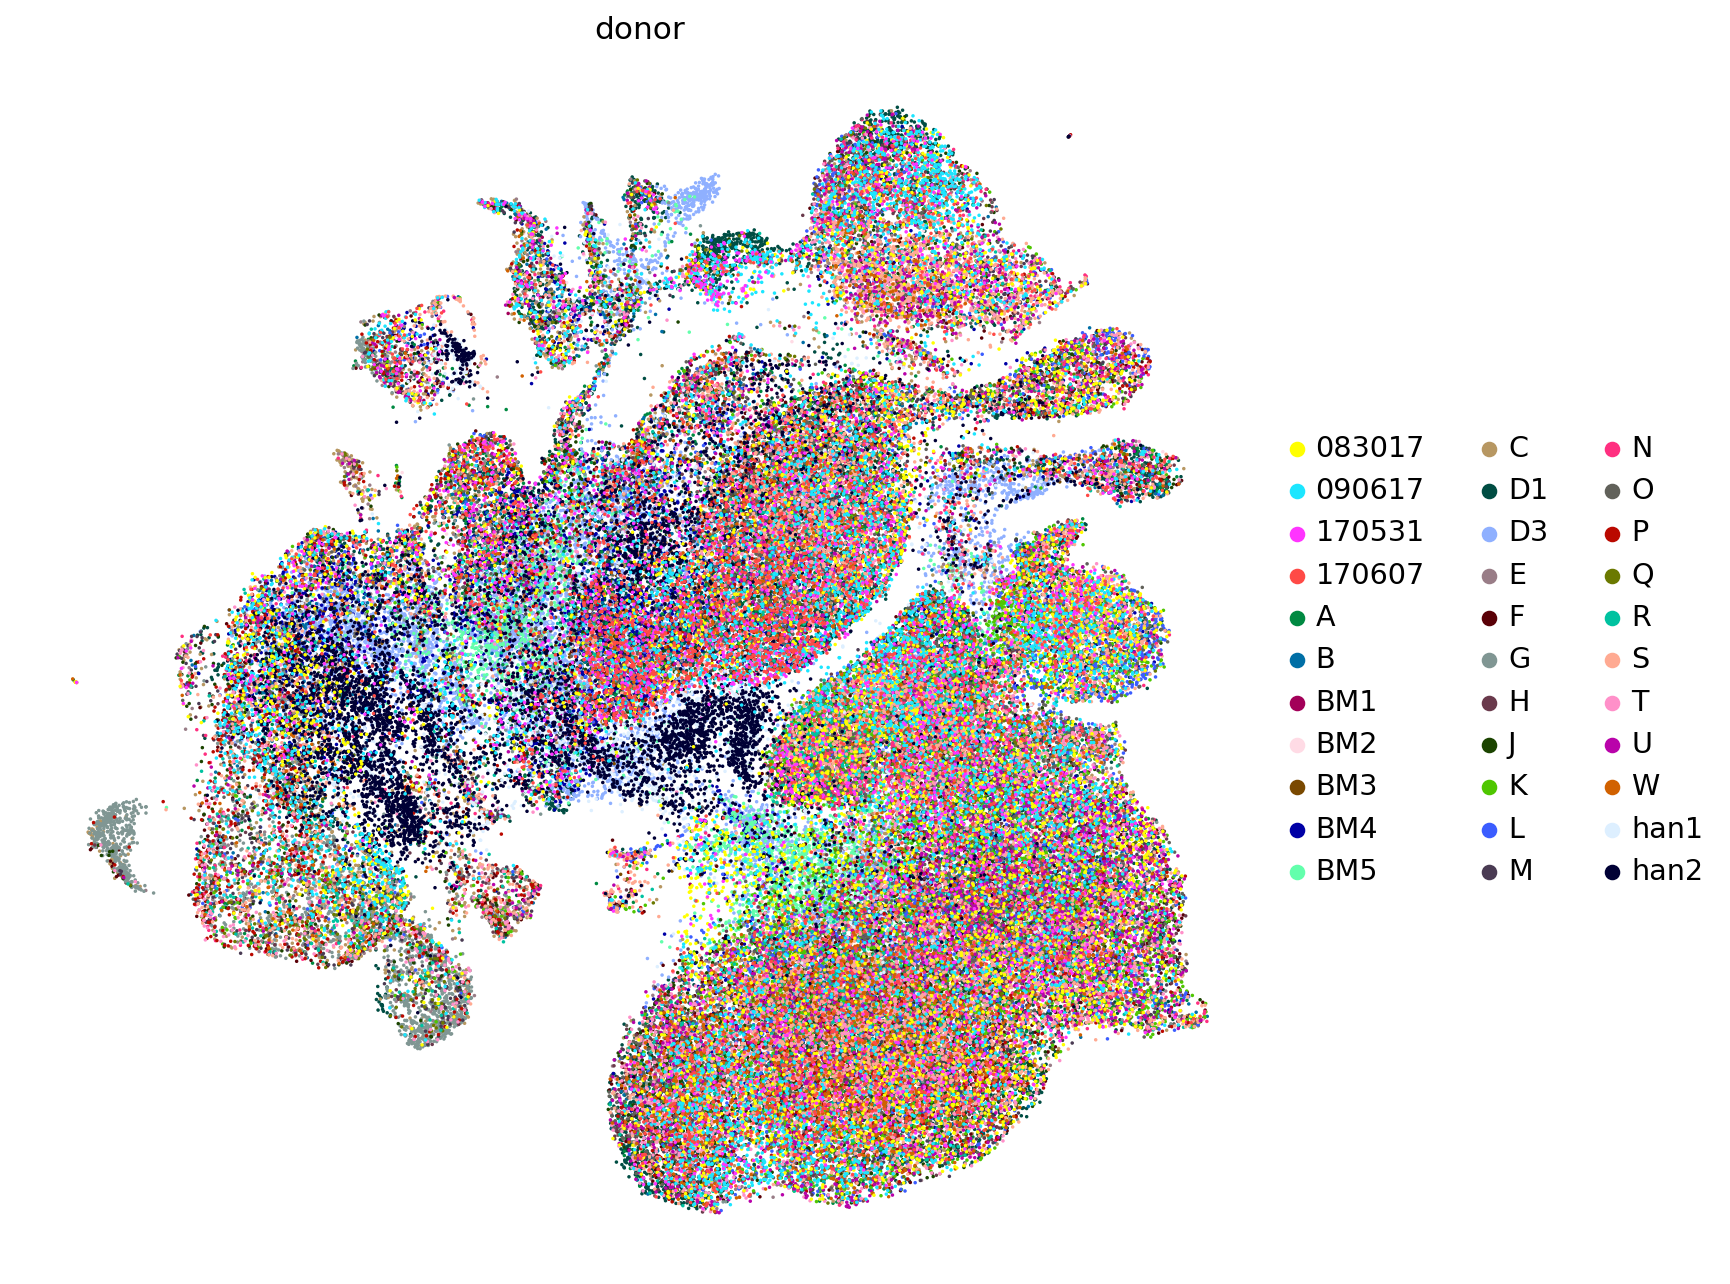

In [74]:
don = np.array(adata_merge.obs['donor'])
don[adata_merge.obs['sample'].str.contains('D1')] = 'D1'
don[adata_merge.obs['sample'].str.contains('D2')] = 'D2'
don[adata_merge.obs['sample'].str.contains('D3')] = 'D3'
don[adata_merge.obs['sample'].str.contains('083017')] = '083017'
don[adata_merge.obs['sample'].str.contains('090617')] = '090617'
don[adata_merge.obs['sample'].str.contains('170531')] = '170531'
don[adata_merge.obs['sample'].str.contains('170607')] = '170607'
don[adata_merge.obs['sample'].str.contains('BoneMarrow_1')] = 'han1'
don[adata_merge.obs['sample'].str.contains('BoneMarrow_2')] = 'han2'
reference_latent.obs['donor'] = don
sc.pl.umap(reference_latent, color=['donor'], frameon=False,
           wspace=0.6, size=10, ncols=1)

In [75]:
reference_latent.obs['dataset'].value_counts()

oetjen    73050
granja    20558
petti     18471
han        8704
vanG       7698
Name: dataset, dtype: int64

In [76]:
reference_latent.obs['sample'].value_counts()

sampleK                 6971
ND_090617               6704
BoneMarrow_2            6443
BMMC_D1T2               6241
BMMC_D1T1               6141
CD34_D3T1               5752
ND_083017               5395
sampleO                 4911
sampleSk2               4612
sampleN                 4256
sampleL                 4243
BM4                     3738
sampleT                 3696
sampleU                 3608
sampleH                 3536
Normal_sorted_170607    3390
sampleF                 3390
sampleW                 3239
Normal_sorted_170531    2982
sampleB                 2825
sampleR                 2745
sampleJ                 2679
sampleG                 2634
sampleM                 2582
CD34_D2T1               2424
sampleA                 2412
sampleP                 2390
BoneMarrow_1            2261
sampleE                 2105
sampleC1                1886
sampleS2                1821
sampleC2                1740
sampleS1                1740
BM5-34p38n              1590
BM5-34p       

In [77]:
reference_latent.obs['donor'].value_counts()

D1        12382
S          9156
D3         8176
K          6971
090617     6704
han2       6443
083017     5395
O          4911
C          4501
N          4256
L          4243
BM4        3738
T          3696
U          3608
H          3536
F          3390
170607     3390
W          3239
BM5        3021
170531     2982
B          2825
R          2745
J          2679
G          2634
M          2582
A          2412
P          2390
han1       2261
E          2105
Q          1171
BM3         643
BM2         188
BM1         108
Name: donor, dtype: int64

In [78]:
reference_latent.obs['celltype'].value_counts()

CD4.M          17654
CD4.N1         15202
Late.Eryth     12132
CD14.Mono.2     8125
CD8.CM          7326
CD8.N           7187
B               7010
CD14.Mono.1     7002
NK              6558
GMP             5809
HSC             4657
GMP.Neut        4633
CMP.LMPP        4405
CD8.EM          3652
Early.Eryth     3028
CD4.N2          2441
CD16.Mono       2376
CLP.1           2094
Pre.B           1883
cDC             1707
pDC             1572
Plasma           974
CLP.2            622
Early.Baso       432
Name: celltype, dtype: int64

In [84]:
print('No. of datasets:', len(set(reference_latent.obs['dataset'])),
     '\nNo. of donors:', len(set(reference_latent.obs['donor'])),
     '\nNo. of samples:', len(set(reference_latent.obs['sample'])),
     '\nNo. of cell types', len(set(reference_latent.obs['celltype'])),
     '\nNo. of cells', reference_latent.n_obs)

No. of datasets: 5 
No. of donors: 33 
No. of samples: 41 
No. of cell types 24 
No. of cells 128481


In [83]:
reference_latent.write('../data/reference_latent.h5ad')